**Simple Linear Regression Model**
- Using Tensorflow
- On Weather Conditions in World War Two Dataset

**Goal :** To predict MaxTemp given MinTemp

**Contents**
* Import Libraries
* Load Data
* Build Model
* Evaluate
* Summary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
data = pd.read_csv('../input/weatherww2/Summary of Weather.csv')
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-

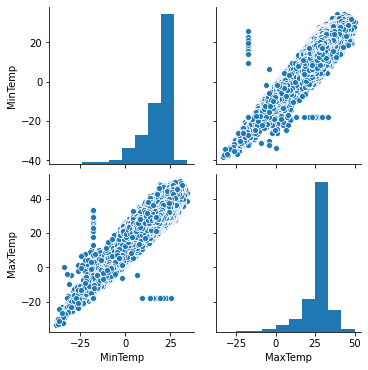

In [4]:
sns.pairplot(data[['MinTemp','MaxTemp']]) # Strong Correlation Between Min and Max Temps

In [5]:
data_new = data[['MinTemp', 'MaxTemp']] # Select columns needed

In [6]:
# Prep Train and Test Data
train_data = data_new.sample(frac=0.8,random_state=42) 
test_data = data_new.drop(train_data.index)

In [7]:
# Get Stats on Train Data
train_stats = train_data.describe()
train_stats.pop("MaxTemp")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MinTemp,95232.0,17.788103,8.339132,-38.333333,15.0,21.111111,23.333333,34.444444


In [8]:
# Create Labels needed for TF model
train_labels = train_data.pop('MaxTemp')
test_labels = test_data.pop('MaxTemp')

### Normalize the Data

In [9]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

### Model

In [10]:
def build_model():
  model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',optimizer=optimizer, metrics=['mae', 'mse'])

  return model

In [11]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Check an example
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.00483985],
       [0.02949737],
       [0.02949737],
       [0.07881238],
       [0.08374392],
       [0.0689494 ],
       [0.04922338],
       [0.00627643],
       [0.00106222],
       [0.03936039]], dtype=float32)

In [13]:
# Train the data
# Added early stopping to avoid overfitting

epochs = 25
history = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split = 0.2, 
                    verbose=0, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
14,14.943709,2.864796,14.943709,15.059136,2.791951,15.059136,14
15,14.948264,2.866306,14.948264,14.885531,2.788985,14.885531,15
16,14.936828,2.863028,14.936828,14.889458,2.822395,14.889458,16
17,14.946026,2.866702,14.946026,14.999647,2.815907,14.999647,17
18,14.935294,2.863553,14.935294,15.062008,2.806148,15.062008,18


### Model Evaluation

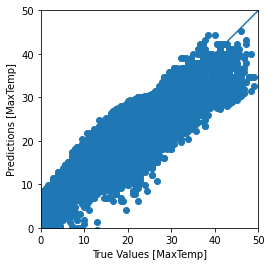

In [15]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MaxTemp]')
plt.ylabel('Predictions [MaxTemp]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

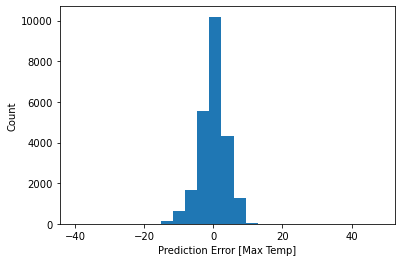

In [16]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Max Temp]")
_ = plt.ylabel("Count")

In [17]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, test_predictions)))

Root Mean Squared Error: 3.895836263995026


### Summary

Here we saw a simple Linear Regression Model using Tensorflow. 